In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
from matplotlib.patches import Rectangle
from matplotlib.ticker import StrMethodFormatter

#### Functions

In [2]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','init_lat']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        data_sec = datafile[var]
        dict_var[var] = data_sec[idx]
        
    
    return dict_var       

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)


def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Latitude (°W)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    # axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-2],2)])
    axn.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axn.add_collection(pc)
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticklabels([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

In [3]:
def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°E)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

In [4]:
def plotTS2(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :,:, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lat[(data.final_section != 0)]
    
    f_lons = mesh.gphif[0,:, latgridf]
    u_lons = mesh.gphiv[0,:, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Latitude (°W)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    # axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-2],2)])
    axn.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axn.add_collection(pc)
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticklabels([])

#### Import data

In [5]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

##Forwards - Eastern JdF
#Jan
datafas = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/foradm_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafds = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/fordec_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafhsvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forharoVS_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafsjvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forsjcVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')
datafrsvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forrosVS_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

#July
datafas07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/foradm_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafds07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/fordec_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafhsvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forharoVS_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafsjvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forsjcVS_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafrsvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forrosVS_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')

##Backwards
databvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backVS_jan18/for_straight_01jan18_s1t21/ariane_positions_quantitative.nc')
databas = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backADM_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')
databds = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backdec_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databsjvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backsjcVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')
databrsvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backrosVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')
databhsvs = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backharoVS_jan18/back_straight_28jan18_s7t28/ariane_positions_quantitative.nc')

#July
databvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backVS_jul18/for_straight_01jul18_s1t21/ariane_positions_quantitative.nc')
databas07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backadm_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databds07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backdec_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databsjvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backsjcVS_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databrsvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backrosVS_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databhsvs07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backharoVS_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')

##Forwards - SJGI
# Jan
datafg1 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf1_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafg2 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf2_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafhspr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forharoPR_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafsjpr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forsjcPR_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafrspr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forrosPR_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
datafpr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18_PR/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

# Jul
datafg107 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf1_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafg207 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forgulf2_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafhspr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forharoPR_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafsjpr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forsjcPR_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafrspr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forrosPR_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
datafpr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/forPR_jul18/for_straight_01jul18_s7t28/ariane_positions_quantitative.nc')

##Backwards
# Jan
databg1 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backgulf1_jan18/back_straight_01jan18_s7t21_check/ariane_positions_quantitative.nc')
databg2 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backgulf2_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databhspr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backharoPR_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databsjpr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backsjcPR_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databrspr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backrosPR_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
databpr = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backPR_jan18/back_straight_01jan18_s7t28/ariane_positions_quantitative.nc')

# Jul
databg107 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backgulf1_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databg207 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backgulf2_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databhspr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backharoPR_jul18/back_straight_01jul18_s7t28/ariane_positions_quantitative.nc')
databsjpr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backsjcPR_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databrspr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backrosPR_jul18/back_straight_28jul18_s7t28/ariane_positions_quantitative.nc')
databpr07 = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/backPR_jul18/for_straight_01jul18_s1t21/ariane_positions_quantitative.nc')

data_dict = {'datafvs':data,'datafas':datafas,'datafds':datafds,'datafrsvs':datafrsvs,'datafsjvs':datafsjvs,'datafhsvs':datafhsvs,
             'datafvs07':datafvs07,'datafas07':datafas07,'datafds07':datafds07,'datafrsvs07':datafrsvs07,'datafsjvs07':datafsjvs07,'datafhsvs07':datafhsvs07,
             'databvs':databvs,'databas':databas,'databds':databds,'databrsvs':databrsvs,'databsjvs':databsjvs,'databhsvs':databhsvs,
             'databvs07':databvs07,'databas07':databas07,'databds07':databds07,'databrsvs07':databrsvs07,'databsjvs07':databsjvs07,'databhsvs07':databhsvs07,
             'datafpr':datafpr,'datafg1':datafg1,'datafg2':datafg2,'datafrspr':datafrspr,'datafsjpr':datafsjpr,'datafhspr':datafhspr,
             'datafpr07':datafpr07,'datafg107':datafg107,'datafg207':datafg207,'datafrspr07':datafrspr07,'datafsjpr07':datafsjpr07,'datafhspr07':datafhspr07,
             'databpr':databpr,'databg1':databg1,'databg2':databg2,'databrspr':databrspr,'databsjpr':databsjpr,'databhspr':databhspr,
             'databpr07':databpr07,'databg107':databg107,'databg207':databg207,'databrspr07':databrspr07,'databsjpr07':databsjpr07,'databhspr07':databhspr07
}

/tmp/ipykernel_17790/2603405835.py:22: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_17790/2603405835.py:22: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_17790/2603405835.py:22: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_17790/2138519952.py:53: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_17790/2138519952.py:53: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_17790/2138519952.py:53: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


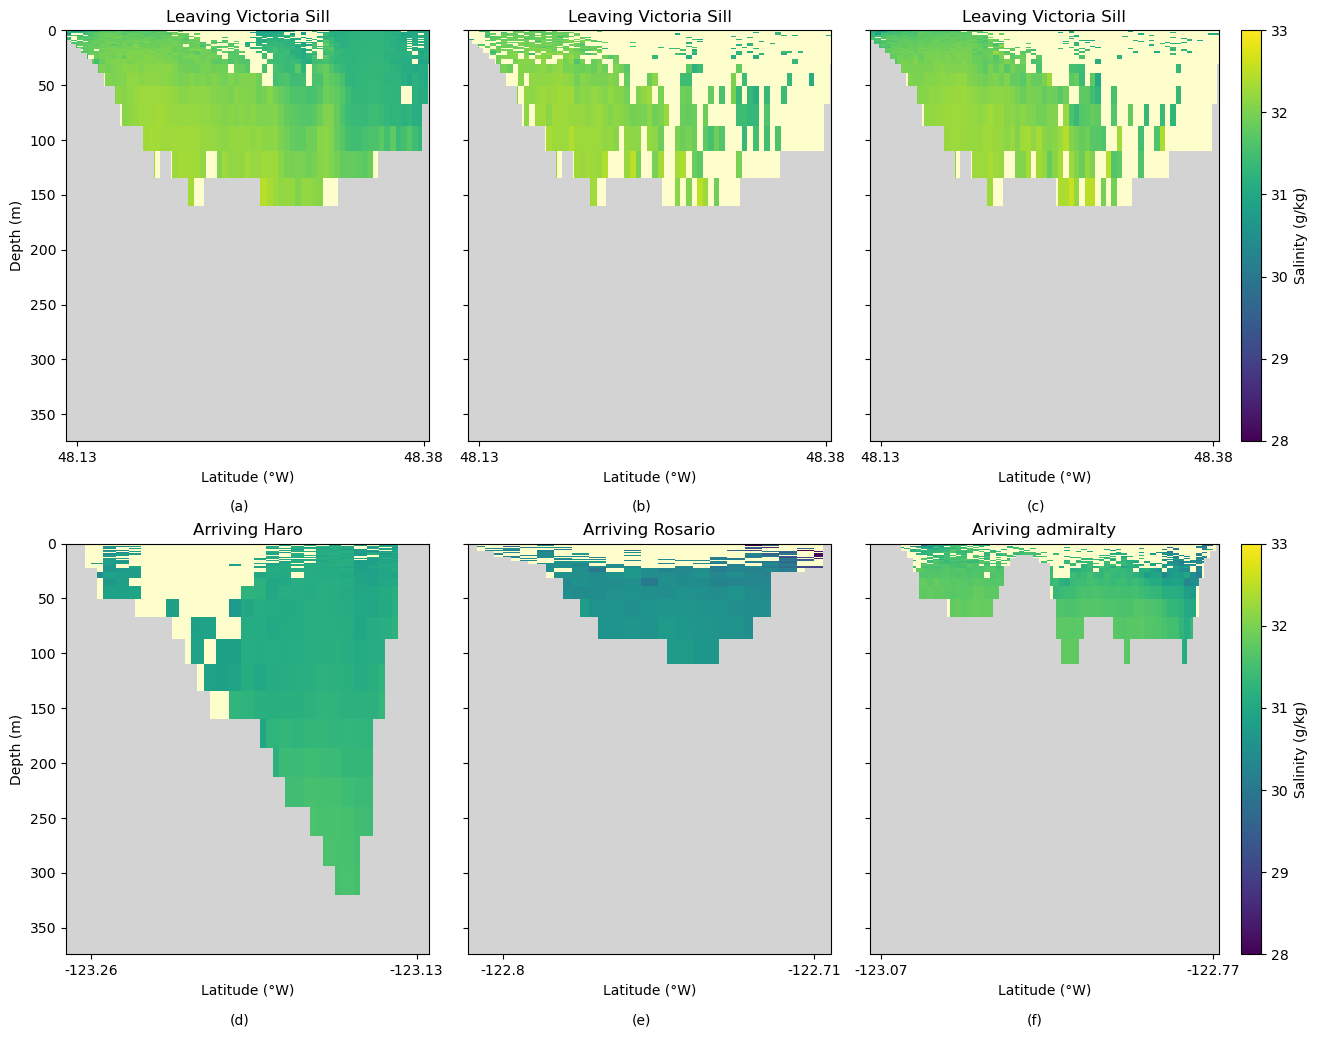

In [30]:
haro_fVS = get_secdata(data_dict['datafvs'],6)
ros_fVS = get_secdata(data_dict['datafvs'],4)
adm_fVS = get_secdata(data_dict['datafvs'],2)

smin = 28
smax = 33

lonWharo = 215
lonEharo = 245
latharo = 300
lonWros=283
lonEros=305
latros = 267
latsjc = 282
lonWsjc = 258
lonEsjc = 268
lonWadm = 200
lonEadm = 262
latadm = 218
lonWg1 = 235
lonEg1 = 253
latg1 = 386
lonWvs = 235
lonEvs = 301
latvs = 177

title = 'Leaving Victoria Sill'
title2 = 'Leaving Victoria Sill'
title3 = 'Leaving Victoria Sill'

title4 = 'Arriving Haro'
title5 = 'Arriving Rosario'
title6 = 'Ariving admiralty'

fig,[[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(2,3,figsize=(16,12),gridspec_kw={'width_ratios':[1,1,1.2]})

plotTS2(ax1,'sal',haro_fVS['init_lat'],haro_fVS['init_z'],haro_fVS['init_salt'],lonWvs,lonEvs,latvs,38,168,title,False,True,vmin=smin,vmax=smax)
plotTS2(ax2,'sal',ros_fVS['init_lat'],ros_fVS['init_z'],ros_fVS['init_salt'],lonWvs,lonEvs,latvs,38,168,title2,False,False,vmin=smin,vmax=smax)
plotTS2(ax3,'sal',adm_fVS['init_lat'],adm_fVS['init_z'],adm_fVS['init_salt'],lonWvs,lonEvs,latvs,38,168,title3,True,False,vmin=smin,vmax=smax)

plotTS(ax4,'sal',haro_fVS['final_lon'],haro_fVS['final_z'],haro_fVS['final_salt'],lonWharo,lonEharo,latharo,38,168,title4,False,True,vmin=smin,vmax=smax)
plotTS(ax5,'sal',ros_fVS['final_lon'],ros_fVS['final_z'],ros_fVS['final_salt'],lonWros,lonEros,latros,38,168,title5,False,False,vmin=smin,vmax=smax)
plotTS(ax6,'sal',adm_fVS['final_lon'],adm_fVS['final_z'],adm_fVS['final_salt'],lonWadm,lonEadm,latadm,38,168,title6,True,False,vmin=smin,vmax=smax)

fig.subplots_adjust(wspace=0.1,hspace=0.25)
ax4.text(0.45, -0.17, "(a)", transform=ax1.transAxes)
ax5.text(0.45, -0.17, "(b)", transform=ax2.transAxes)
ax6.text(0.45, -0.17, "(c)", transform=ax3.transAxes)
ax4.text(0.45, -0.17, "(d)", transform=ax4.transAxes)
ax5.text(0.45, -0.17, "(e)", transform=ax5.transAxes)
ax6.text(0.45, -0.17, "(f)", transform=ax6.transAxes)

fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/salinity_fvs_crosssection.png',bbox_inches='tight')

/tmp/ipykernel_17790/2603405835.py:22: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_17790/2603405835.py:22: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_17790/2603405835.py:22: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_17790/2138519952.py:53: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_17790/2138519952.py:53: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_17790/2138519952.py:53: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


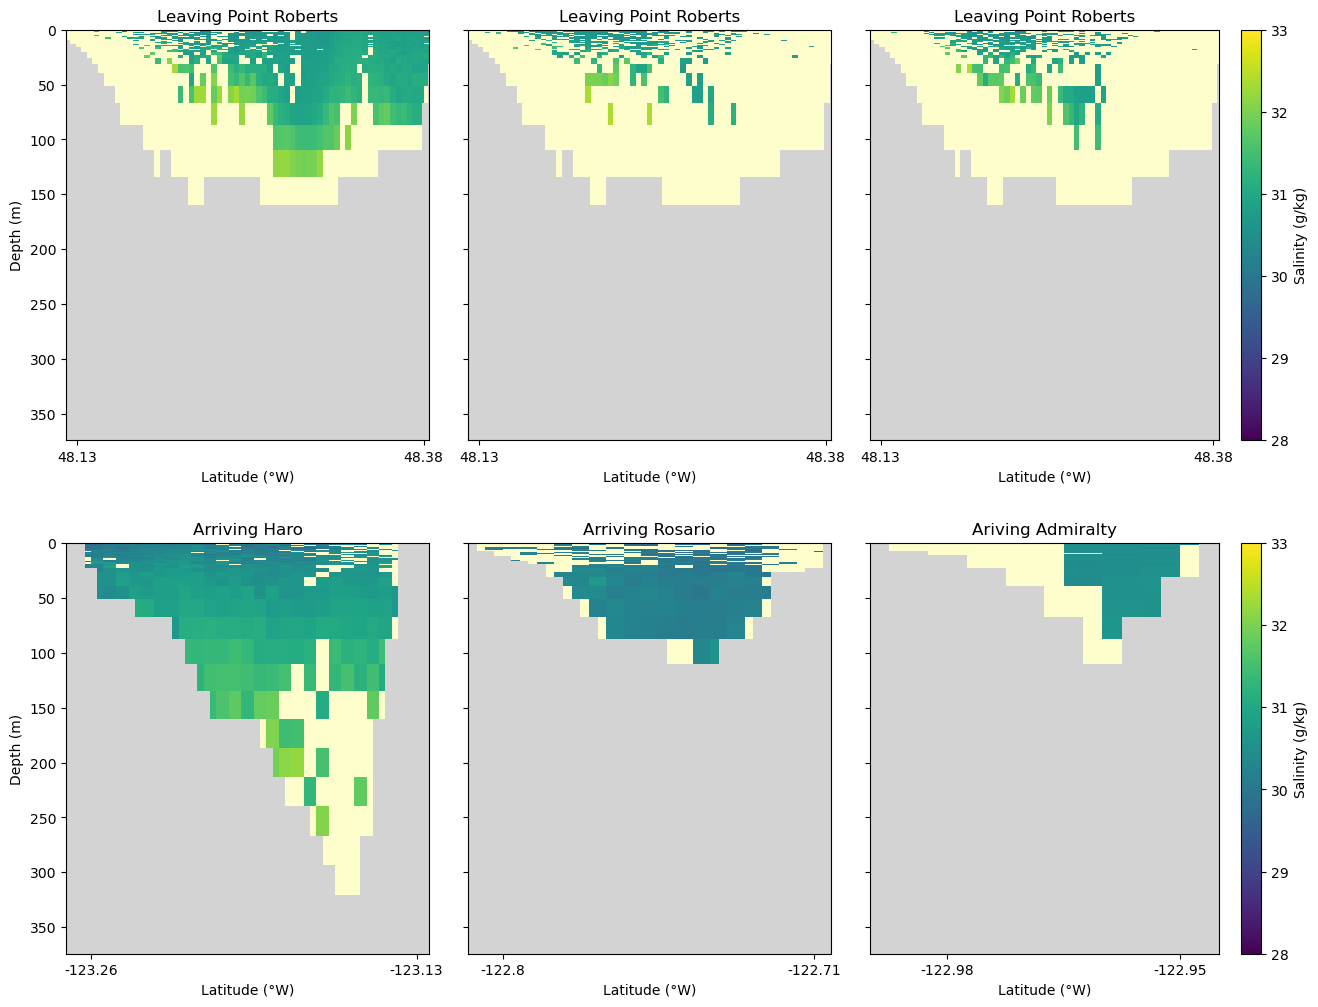

In [7]:
haro_bVS = get_secdata(data_dict['databvs'],6)
ros_bVS = get_secdata(data_dict['databvs'],4)
adm_bVS = get_secdata(data_dict['databvs'],5)

title = 'Leaving Point Roberts'
title2 = 'Leaving Point Roberts'
title3 = 'Leaving Point Roberts'

title4 = 'Arriving Haro'
title5 = 'Arriving Rosario'
title6 = 'Ariving Admiralty'

lonWpr = 260
lonEpr = 310
latpr = 386

fig,[[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(2,3,figsize=(16,12),gridspec_kw={'width_ratios':[1,1,1.2]})

plotTS2(ax1,'sal',haro_bVS['init_lat'],haro_bVS['init_z'],haro_bVS['init_salt'],lonWvs,lonEvs,latvs,38,168,title,False,True,vmin=smin,vmax=smax)
plotTS2(ax2,'sal',ros_bVS['init_lat'],ros_bVS['init_z'],ros_bVS['init_salt'],lonWvs,lonEvs,latvs,38,168,title2,False,False,vmin=smin,vmax=smax)
plotTS2(ax3,'sal',adm_bVS['init_lat'],adm_bVS['init_z'],adm_bVS['init_salt'],lonWvs,lonEvs,latvs,38,168,title3,True,False,vmin=smin,vmax=smax)

plotTS(ax4,'sal',haro_bVS['final_lon'],haro_bVS['final_z'],haro_bVS['final_salt'],lonWharo,lonEharo,latharo,38,168,title4,False,True,vmin=smin,vmax=smax)
plotTS(ax5,'sal',ros_bVS['final_lon'],ros_bVS['final_z'],ros_bVS['final_salt'],lonWros,lonEros,latros,38,168,title5,False,False,vmin=smin,vmax=smax)
plotTS(ax6,'sal',adm_bVS['final_lon'],adm_bVS['final_z'],adm_bVS['final_salt'],lonWsjc,lonEsjc,latsjc,38,168,title6,True,False,vmin=smin,vmax=smax)

fig.subplots_adjust(wspace=0.1,hspace=0.25)

/tmp/ipykernel_17790/2138519952.py:53: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_17790/2138519952.py:53: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_17790/2138519952.py:53: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_17790/2138519952.py:53: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_17790/2138519952.py:53: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw
/tmp/ipykernel_17790/2138519952.py:53: RuntimeWarning: invalid value encountered in divide
  arr3 = arrw/arrnw


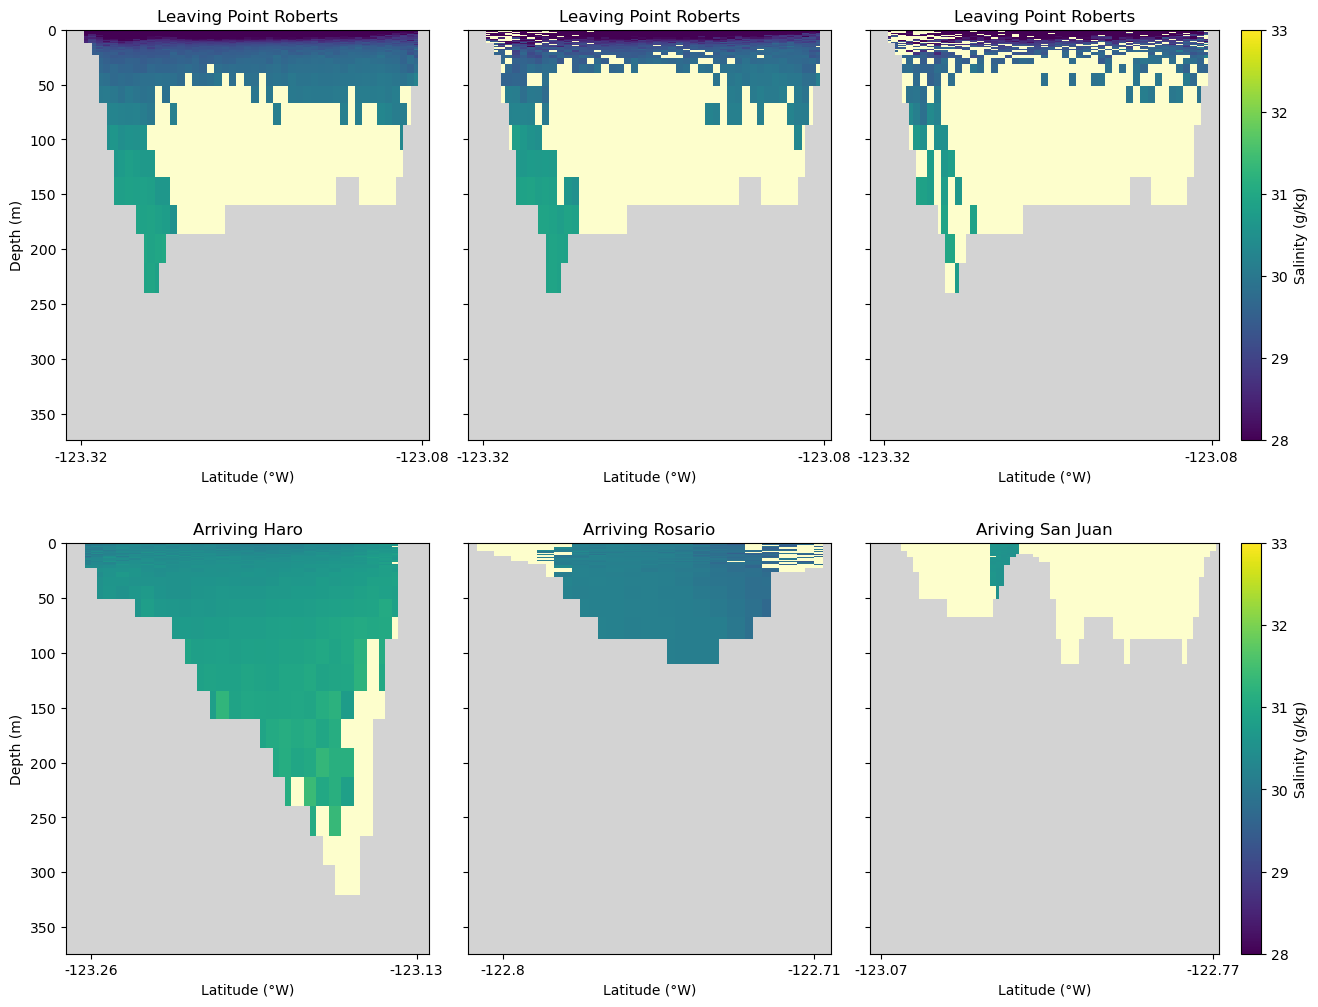

In [8]:
haro_fPR = get_secdata(data_dict['datafpr'],6)
ros_fPR = get_secdata(data_dict['datafpr'],4)
sjc_fPR = get_secdata(data_dict['datafpr'],5)

title = 'Leaving Point Roberts'
title2 = 'Leaving Point Roberts'
title3 = 'Leaving Point Roberts'

title4 = 'Arriving Haro'
title5 = 'Arriving Rosario'
title6 = 'Ariving San Juan'

lonWpr = 260
lonEpr = 310
latpr = 386

fig,[[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(2,3,figsize=(16,12),gridspec_kw={'width_ratios':[1,1,1.2]})

plotTS(ax1,'sal',haro_fPR['init_lon'],haro_fPR['init_z'],haro_fPR['init_salt'],lonWpr,lonEpr,latpr,38,168,title,False,True,vmin=smin,vmax=smax)
plotTS(ax2,'sal',ros_fPR['init_lon'],ros_fPR['init_z'],ros_fPR['init_salt'],lonWpr,lonEpr,latpr,38,168,title2,False,False,vmin=smin,vmax=smax)
plotTS(ax3,'sal',sjc_fPR['init_lon'],sjc_fPR['init_z'],sjc_fPR['init_salt'],lonWpr,lonEpr,latpr,38,168,title3,True,False,vmin=smin,vmax=smax)

plotTS(ax4,'sal',haro_fPR['final_lon'],haro_fPR['final_z'],haro_fPR['final_salt'],lonWharo,lonEharo,latharo,38,168,title4,False,True,vmin=smin,vmax=smax)
plotTS(ax5,'sal',ros_fPR['final_lon'],ros_fPR['final_z'],ros_fPR['final_salt'],lonWros,lonEros,latros,38,168,title5,False,False,vmin=smin,vmax=smax)
plotTS(ax6,'sal',sjc_fPR['final_lon'],sjc_fPR['final_z'],sjc_fPR['final_salt'],lonWadm,lonEadm,latadm,38,168,title6,True,False,vmin=smin,vmax=smax)

fig.subplots_adjust(wspace=0.1,hspace=0.25)

Look at histogram instead

(29.5, 33.0)

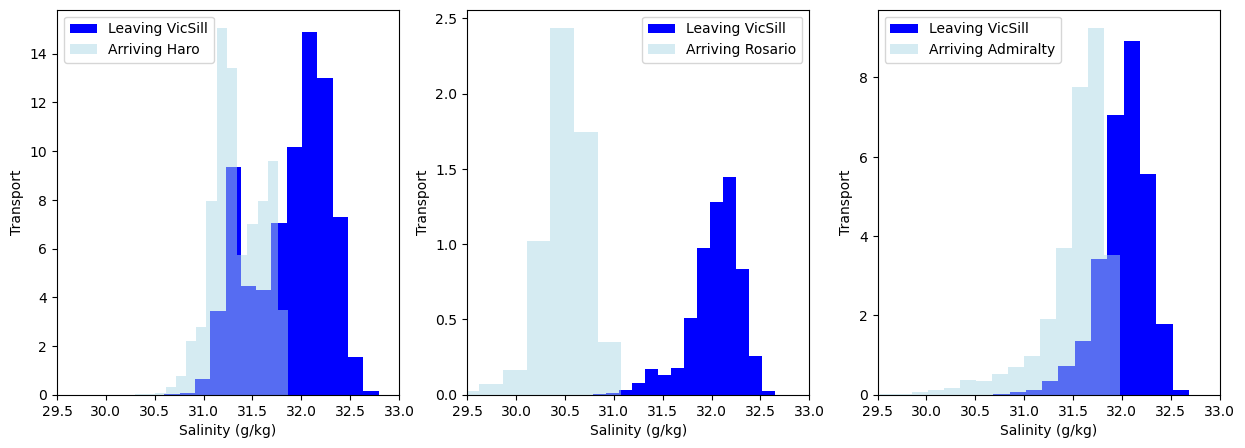

In [9]:
time = 168

fig,ax = plt.subplots(1,3,figsize=(15,5))

ax[1].hist(ros_fVS['init_salt'],bins=15,weights=ros_fVS['init_transp']/time/1000,color='blue',label='Leaving VicSill')
ax[1].hist(ros_fVS['final_salt'],bins=15,weights=ros_fVS['final_transp']/time/1000,color='lightblue',alpha=0.5,label='Arriving Rosario')
ax[1].set_ylabel('Transport')
ax[1].set_xlabel('Salinity (g/kg)')
ax[1].legend()
ax[0].hist(haro_fVS['init_salt'],bins=15,weights=haro_fVS['init_transp']/time/1000,color='blue',label='Leaving VicSill')
ax[0].hist(haro_fVS['final_salt'],bins=15,weights=haro_fVS['final_transp']/time/1000,color='lightblue',alpha=0.5,label='Arriving Haro')
ax[0].legend()
ax[0].set_ylabel('Transport')
ax[0].set_xlabel('Salinity (g/kg)')
ax[2].hist(adm_fVS['init_salt'],bins=15,weights=adm_fVS['init_transp']/time/1000,color='blue',label='Leaving VicSill')
ax[2].hist(adm_fVS['final_salt'],bins=15,weights=adm_fVS['final_transp']/time/1000,color='lightblue',alpha=0.5,label='Arriving Admiralty')
ax[2].set_ylabel('Transport')
ax[2].set_xlabel('Salinity (g/kg)')
ax[2].legend()
ax[0].set_xlim([29.5,33])
ax[1].set_xlim([29.5,33])
ax[2].set_xlim([29.5,33])

Text(0.45, -0.17, '(f)')

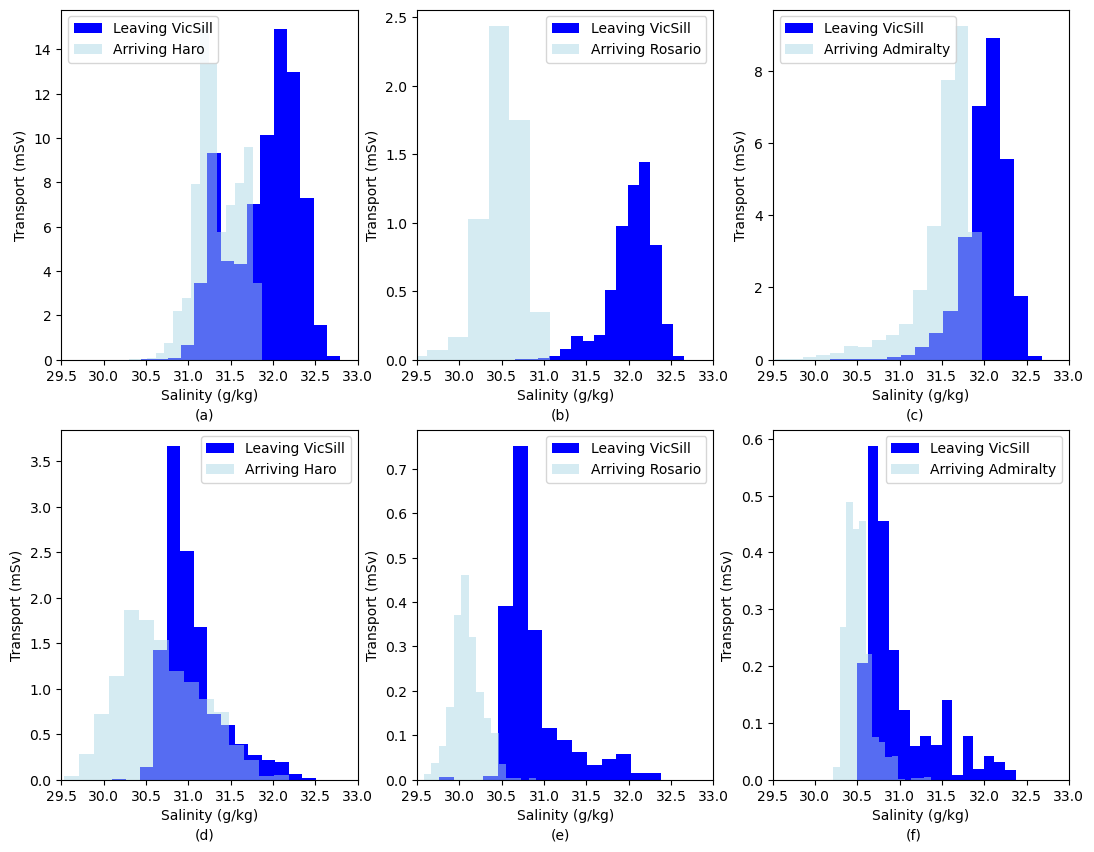

In [10]:
time = 168

fig,[[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(2,3,figsize=(13,10))

ax2.hist(ros_fVS['init_salt'],bins=15,weights=ros_fVS['init_transp']/time/1000,color='blue',label='Leaving VicSill')
ax2.hist(ros_fVS['final_salt'],bins=15,weights=ros_fVS['final_transp']/time/1000,color='lightblue',alpha=0.5,label='Arriving Rosario')
ax2.set_ylabel('Transport (mSv)')
ax2.set_xlabel('Salinity (g/kg)')
ax2.legend()
ax1.hist(haro_fVS['init_salt'],bins=15,weights=haro_fVS['init_transp']/time/1000,color='blue',label='Leaving VicSill')
ax1.hist(haro_fVS['final_salt'],bins=15,weights=haro_fVS['final_transp']/time/1000,color='lightblue',alpha=0.5,label='Arriving Haro')
ax1.legend()
ax1.set_ylabel('Transport (mSv)')
ax1.set_xlabel('Salinity (g/kg)')
ax3.hist(adm_fVS['init_salt'],bins=15,weights=adm_fVS['init_transp']/time/1000,color='blue',label='Leaving VicSill')
ax3.hist(adm_fVS['final_salt'],bins=15,weights=adm_fVS['final_transp']/time/1000,color='lightblue',alpha=0.5,label='Arriving Admiralty')
ax3.set_ylabel('Transport (mSv)')
ax3.set_xlabel('Salinity (g/kg)')
ax3.legend()
ax1.set_xlim([29.5,33])
ax2.set_xlim([29.5,33])
ax3.set_xlim([29.5,33])

ax5.hist(ros_bVS['init_salt'],bins=15,weights=ros_bVS['init_transp']/time/1000,color='blue',label='Leaving VicSill')
ax5.hist(ros_bVS['final_salt'],bins=15,weights=ros_bVS['final_transp']/time/1000,color='lightblue',alpha=0.5,label='Arriving Rosario')
ax5.set_ylabel('Transport (mSv)')
ax5.set_xlabel('Salinity (g/kg)')
ax5.legend()
ax4.hist(haro_bVS['init_salt'],bins=15,weights=haro_bVS['init_transp']/time/1000,color='blue',label='Leaving VicSill')
ax4.hist(haro_bVS['final_salt'],bins=15,weights=haro_bVS['final_transp']/time/1000,color='lightblue',alpha=0.5,label='Arriving Haro')
ax4.legend()
ax4.set_ylabel('Transport (mSv)')
ax4.set_xlabel('Salinity (g/kg)')
ax6.hist(adm_bVS['init_salt'],bins=15,weights=adm_bVS['init_transp']/time/1000,color='blue',label='Leaving VicSill')
ax6.hist(adm_bVS['final_salt'],bins=15,weights=adm_bVS['final_transp']/time/1000,color='lightblue',alpha=0.5,label='Arriving Admiralty')
ax6.set_ylabel('Transport (mSv)')
ax6.set_xlabel('Salinity (g/kg)')
ax6.legend()
ax4.set_xlim([29.5,33])
ax5.set_xlim([29.5,33])
ax6.set_xlim([29.5,33])

ax1.text(0.45, -0.17, "(a)", transform=ax1.transAxes)
ax2.text(0.45, -0.17, "(b)", transform=ax2.transAxes)
ax3.text(0.45, -0.17, "(c)", transform=ax3.transAxes)

ax4.text(0.45, -0.17, "(d)", transform=ax4.transAxes)
ax5.text(0.45, -0.17, "(e)", transform=ax5.transAxes)
ax6.text(0.45, -0.17, "(f)", transform=ax6.transAxes)


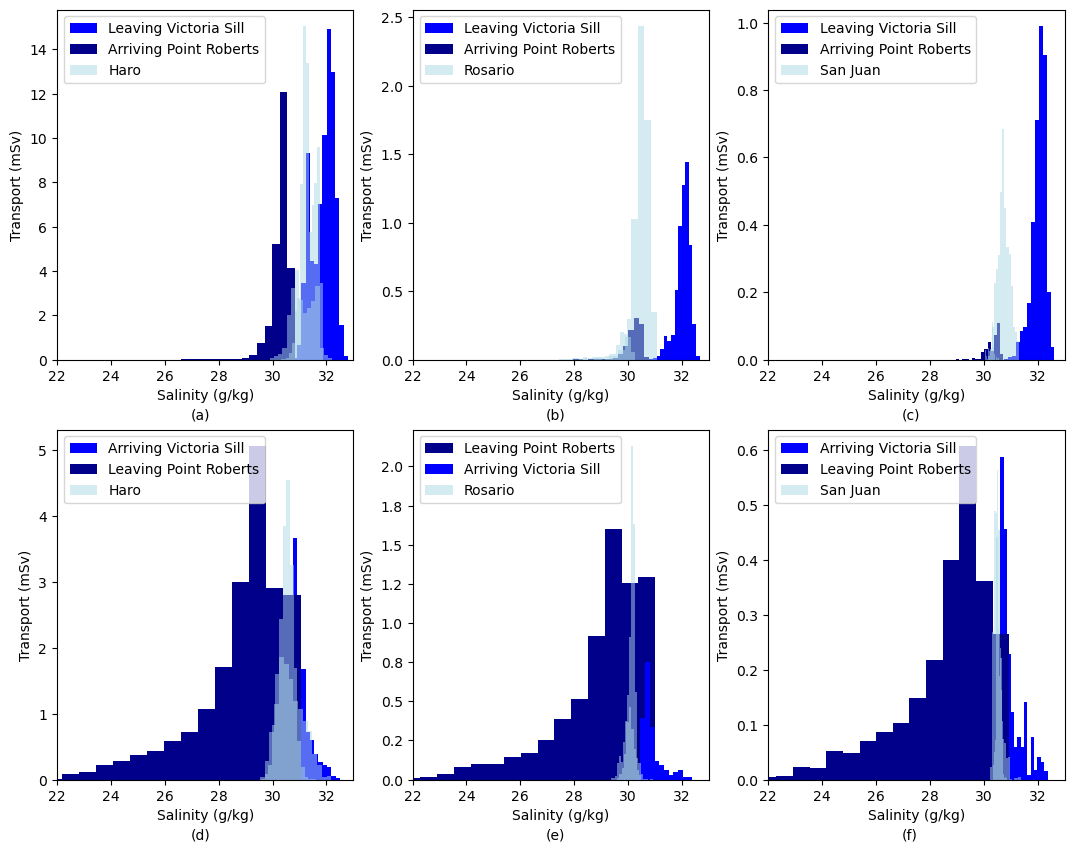

In [26]:
time = 168
sjc_bVS = get_secdata(data_dict['databvs'],5)
sjc_fVS = get_secdata(data_dict['datafvs'],5)
haro_bPR = get_secdata(data_dict['databpr'],6)
ros_bPR = get_secdata(data_dict['databpr'],4)
sjc_bPR = get_secdata(data_dict['databpr'],5)

fig,[[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(2,3,figsize=(13,10))

ax2.hist(ros_fVS['init_salt'],bins=15,weights=ros_fVS['init_transp']/time/1000,color='blue',label='Leaving Victoria Sill')
ax2.hist(ros_bPR['init_salt'],bins=15,weights=ros_bPR['init_transp']/time/1000,color='darkblue',label='Arriving Point Roberts')
ax2.hist(ros_fVS['final_salt'],bins=15,weights=ros_fVS['final_transp']/time/1000,color='lightblue',alpha=0.5,label='Rosario')
ax2.hist(ros_bPR['final_salt'],bins=15,weights=ros_bPR['final_transp']/time/1000,color='lightblue',alpha=0.5)
ax2.set_ylabel('Transport (mSv)')
ax2.set_xlabel('Salinity (g/kg)')
ax2.legend()
ax1.hist(haro_fVS['init_salt'],bins=15,weights=haro_fVS['init_transp']/time/1000,color='blue',label='Leaving Victoria Sill')
ax1.hist(haro_bPR['init_salt'],bins=15,weights=haro_bPR['init_transp']/time/1000,color='darkblue',label='Arriving Point Roberts')
ax1.hist(haro_fVS['final_salt'],bins=15,weights=haro_fVS['final_transp']/time/1000,color='lightblue',alpha=0.5,label='Haro')
ax1.hist(haro_bPR['final_salt'],bins=15,weights=haro_bPR['final_transp']/time/1000,color='lightblue',alpha=0.5)
ax1.legend()
ax1.set_ylabel('Transport (mSv)')
ax1.set_xlabel('Salinity (g/kg)')
ax3.hist(sjc_fVS['init_salt'],bins=15,weights=sjc_fVS['init_transp']/time/1000,color='blue',label='Leaving Victoria Sill')
ax3.hist(sjc_bPR['init_salt'],bins=15,weights=sjc_bPR['init_transp']/time/1000,color='darkblue',label='Arriving Point Roberts')
ax3.hist(sjc_fVS['final_salt'],bins=15,weights=sjc_fVS['final_transp']/time/1000,color='lightblue',alpha=0.5,label='San Juan')
ax3.hist(sjc_bPR['final_salt'],bins=15,weights=sjc_bPR['final_transp']/time/1000,color='lightblue',alpha=0.5)
ax3.set_ylabel('Transport (mSv)')
ax3.set_xlabel('Salinity (g/kg)')
ax3.legend()
ax1.set_xlim([22,33])
ax2.set_xlim([22,33])
ax3.set_xlim([22,33])

ax5.hist(ros_fPR['init_salt'],bins=15,weights=ros_fPR['init_transp']/time/1000,color='darkblue',label='Leaving Point Roberts')
ax5.hist(ros_bVS['init_salt'],bins=15,weights=ros_bVS['init_transp']/time/1000,color='blue',label='Arriving Victoria Sill')
ax5.hist(ros_bVS['final_salt'],bins=15,weights=ros_bVS['final_transp']/time/1000,color='lightblue',alpha=0.5,label='Rosario')
ax5.hist(ros_fPR['final_salt'],bins=15,weights=ros_fPR['final_transp']/time/1000,color='lightblue',alpha=0.5)
ax5.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{1}f}}'))
ax5.set_ylabel('Transport (mSv)')
ax5.set_xlabel('Salinity (g/kg)')
ax5.legend()
ax4.hist(haro_bVS['init_salt'],bins=15,weights=haro_bVS['init_transp']/time/1000,color='blue',label='Arriving Victoria Sill')
ax4.hist(haro_fPR['init_salt'],bins=15,weights=haro_fPR['init_transp']/time/1000,color='darkblue',label='Leaving Point Roberts')
ax4.hist(haro_bVS['final_salt'],bins=15,weights=haro_bVS['final_transp']/time/1000,color='lightblue',alpha=0.5,label='Haro')
ax4.hist(haro_fPR['final_salt'],bins=15,weights=haro_fPR['final_transp']/time/1000,color='lightblue',alpha=0.5)
ax4.legend()
ax4.set_ylabel('Transport (mSv)')
ax4.set_xlabel('Salinity (g/kg)')
ax6.hist(sjc_bVS['init_salt'],bins=15,weights=sjc_bVS['init_transp']/time/1000,color='blue',label='Arriving Victoria Sill')
ax6.hist(sjc_fPR['init_salt'],bins=15,weights=sjc_fPR['init_transp']/time/1000,color='darkblue',label='Leaving Point Roberts')
ax6.hist(sjc_bVS['final_salt'],bins=15,weights=sjc_bVS['final_transp']/time/1000,color='lightblue',alpha=0.5,label='San Juan')
ax6.hist(sjc_fPR['final_salt'],bins=15,weights=sjc_fPR['final_transp']/time/1000,color='lightblue',alpha=0.5)
ax6.set_ylabel('Transport (mSv)')
ax6.set_xlabel('Salinity (g/kg)')
ax6.legend()
ax4.set_xlim([22,33])
ax5.set_xlim([22,33])
ax6.set_xlim([22,33])

ax1.text(0.45, -0.17, "(a)", transform=ax1.transAxes)
ax2.text(0.45, -0.17, "(b)", transform=ax2.transAxes)
ax3.text(0.45, -0.17, "(c)", transform=ax3.transAxes)

ax4.text(0.45, -0.17, "(d)", transform=ax4.transAxes)
ax5.text(0.45, -0.17, "(e)", transform=ax5.transAxes)
ax6.text(0.45, -0.17, "(f)", transform=ax6.transAxes)
fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/salinity_modification_jan.png',bbox_inches='tight')


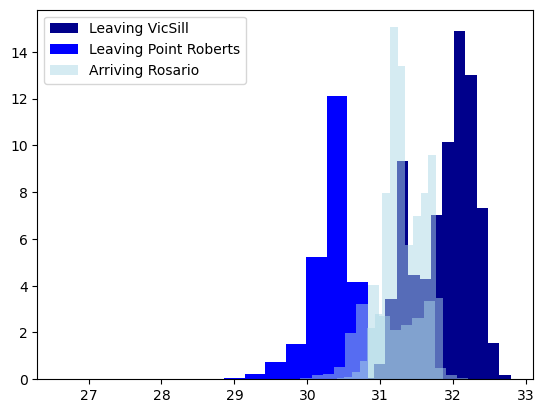

In [12]:
fig,ax = plt.subplots()

ax.hist(haro_fVS['init_salt'],bins=15,weights=haro_fVS['init_transp']/time/1000,color='darkblue',label='Leaving VicSill')
ax.hist(haro_bPR['init_salt'],bins=15,weights=haro_bPR['init_transp']/time/1000,color='blue',label='Leaving Point Roberts')
ax.hist(haro_fVS['final_salt'],bins=15,weights=haro_fVS['final_transp']/time/1000,color='lightblue',alpha=0.5,label='Arriving Rosario')
ax.hist(haro_bPR['final_salt'],bins=15,weights=haro_bPR['final_transp']/time/1000,color='lightblue',alpha=0.5)

ax.legend()

### Summer

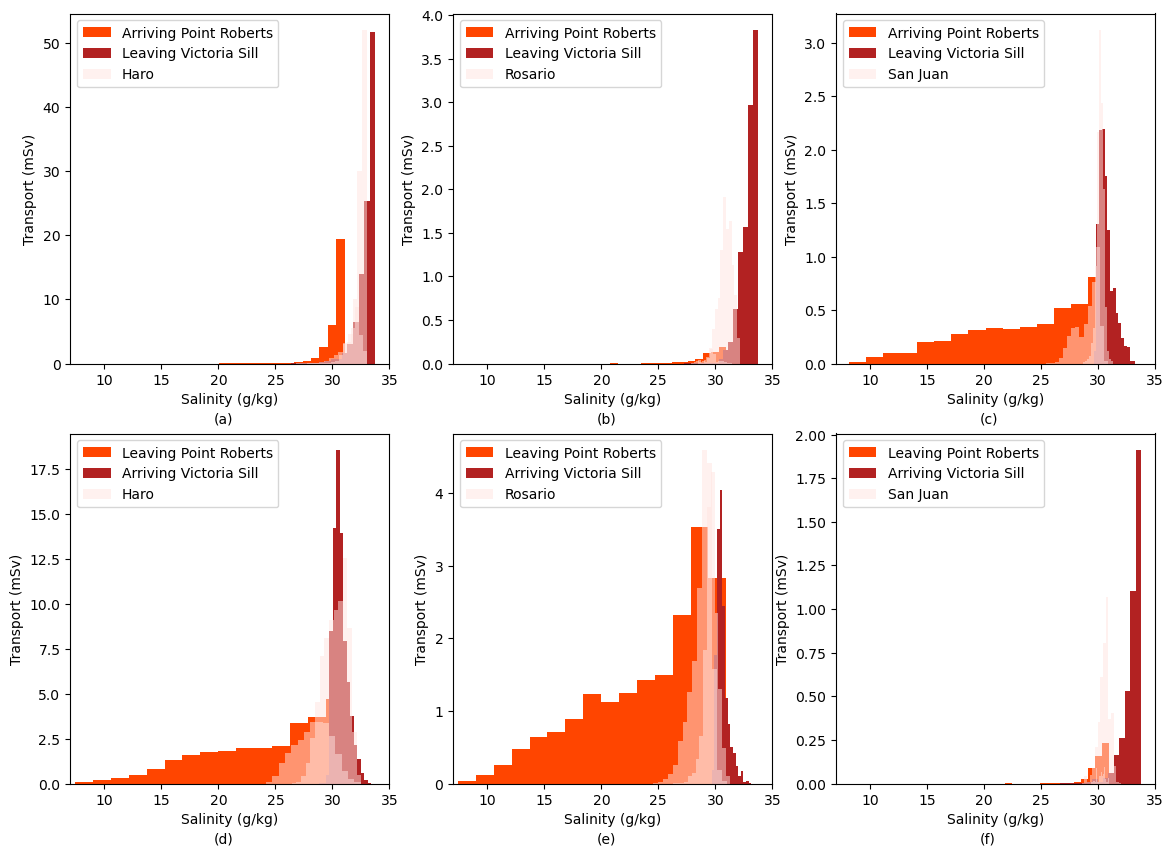

In [27]:
haro_bPR07 = get_secdata(data_dict['databpr07'],6)
ros_bPR07 = get_secdata(data_dict['databpr07'],4)
sjc_bPR07 = get_secdata(data_dict['databpr07'],5)

haro_fPR07 = get_secdata(data_dict['datafpr07'],6)
ros_fPR07 = get_secdata(data_dict['datafpr07'],4)
sjc_fPR07 = get_secdata(data_dict['datafpr07'],5)

haro_bVS07 = get_secdata(data_dict['databvs07'],6)
ros_bVS07 = get_secdata(data_dict['databvs07'],4)
sjc_bVS07 = get_secdata(data_dict['databvs07'],5)

haro_fVS07 = get_secdata(data_dict['datafvs07'],6)
ros_fVS07 = get_secdata(data_dict['datafvs07'],4)
sjc_fVS07 = get_secdata(data_dict['datafvs07'],5)


fig,[[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(2,3,figsize=(14,10))


ax2.hist(ros_bPR07['init_salt'],bins=15,weights=ros_bPR07['init_transp']/time/1000,color='orangered',label='Arriving Point Roberts')
ax2.hist(ros_fVS07['init_salt'],bins=15,weights=ros_fVS07['init_transp']/time/1000,color='firebrick',label='Leaving Victoria Sill')
ax2.hist(ros_fVS07['final_salt'],bins=15,weights=ros_fVS07['final_transp']/time/1000,color='mistyrose',alpha=0.5,label='Rosario')
ax2.hist(ros_bPR07['final_salt'],bins=15,weights=ros_bPR07['final_transp']/time/1000,color='mistyrose',alpha=0.5)
ax2.set_ylabel('Transport (mSv)')
ax2.set_xlabel('Salinity (g/kg)')
ax2.legend()
ax1.hist(haro_bPR07['init_salt'],bins=15,weights=haro_bPR07['init_transp']/time/1000,color='orangered',label='Arriving Point Roberts')
ax1.hist(haro_fVS07['init_salt'],bins=15,weights=haro_fVS07['init_transp']/time/1000,color='firebrick',label='Leaving Victoria Sill')
ax1.hist(haro_fVS07['final_salt'],bins=15,weights=haro_fVS07['final_transp']/time/1000,color='mistyrose',alpha=0.5,label='Haro')
ax1.hist(haro_bPR07['final_salt'],bins=15,weights=haro_bPR07['final_transp']/time/1000,color='mistyrose',alpha=0.5)
ax1.legend()
ax1.set_ylabel('Transport (mSv)')
ax1.set_xlabel('Salinity (g/kg)')
ax3.hist(sjc_fPR07['init_salt'],bins=15,weights=sjc_fPR07['init_transp']/time/1000,color='orangered',label='Arriving Point Roberts')
ax3.hist(sjc_bVS07['init_salt'],bins=15,weights=sjc_bVS07['init_transp']/time/1000,color='firebrick',label='Leaving Victoria Sill')
ax3.hist(sjc_bVS07['final_salt'],bins=15,weights=sjc_bVS07['final_transp']/time/1000,color='mistyrose',alpha=0.5,label='San Juan')
ax3.hist(sjc_fPR07['final_salt'],bins=15,weights=sjc_fPR07['final_transp']/time/1000,color='mistyrose',alpha=0.5)
ax3.set_ylabel('Transport (mSv)')
ax3.set_xlabel('Salinity (g/kg)')
ax3.legend()
ax1.set_xlim([7,35])
ax2.set_xlim([7,35])
ax3.set_xlim([7,35])

ax5.hist(ros_fPR07['init_salt'],bins=15,weights=ros_fPR07['init_transp']/time/1000,color='orangered',label='Leaving Point Roberts')
ax5.hist(ros_bVS07['init_salt'],bins=15,weights=ros_bVS07['init_transp']/time/1000,color='firebrick',label='Arriving Victoria Sill')
ax5.hist(ros_bVS07['final_salt'],bins=15,weights=ros_bVS07['final_transp']/time/1000,color='mistyrose',alpha=0.5,label='Rosario')
ax5.hist(ros_fPR07['final_salt'],bins=15,weights=ros_fPR07['final_transp']/time/1000,color='mistyrose',alpha=0.5)
ax5.set_ylabel('Transport (mSv)')
ax5.set_xlabel('Salinity (g/kg)')
ax5.legend()
ax4.hist(haro_fPR07['init_salt'],bins=15,weights=haro_fPR07['init_transp']/time/1000,color='orangered',label='Leaving Point Roberts')
ax4.hist(haro_bVS07['init_salt'],bins=15,weights=haro_bVS07['init_transp']/time/1000,color='firebrick',label='Arriving Victoria Sill')
ax4.hist(haro_bVS07['final_salt'],bins=15,weights=haro_bVS07['final_transp']/time/1000,color='mistyrose',alpha=0.5,label='Haro')
ax4.hist(haro_fPR07['final_salt'],bins=15,weights=haro_fPR07['final_transp']/time/1000,color='mistyrose',alpha=0.5)
ax4.legend()
ax4.set_ylabel('Transport (mSv)')
ax4.set_xlabel('Salinity (g/kg)')
ax6.hist(sjc_bPR07['init_salt'],bins=15,weights=sjc_bPR07['init_transp']/time/1000,color='orangered',label='Leaving Point Roberts')
ax6.hist(sjc_fVS07['init_salt'],bins=15,weights=sjc_fVS07['init_transp']/time/1000,color='firebrick',label='Arriving Victoria Sill')
ax6.hist(sjc_fVS07['final_salt'],bins=15,weights=sjc_fVS07['final_transp']/time/1000,color='mistyrose',alpha=0.5,label='San Juan')
ax6.hist(sjc_bPR07['final_salt'],bins=15,weights=sjc_bPR07['final_transp']/time/1000,color='mistyrose',alpha=0.5)
ax6.set_ylabel('Transport (mSv)')
ax6.set_xlabel('Salinity (g/kg)')
ax6.legend()
ax4.set_xlim([7,35])
ax5.set_xlim([7,35])
ax6.set_xlim([7,35])

ax1.text(0.45, -0.17, "(a)", transform=ax1.transAxes)
ax2.text(0.45, -0.17, "(b)", transform=ax2.transAxes)
ax3.text(0.45, -0.17, "(c)", transform=ax3.transAxes)

ax4.text(0.45, -0.17, "(d)", transform=ax4.transAxes)
ax5.text(0.45, -0.17, "(e)", transform=ax5.transAxes)
ax6.text(0.45, -0.17, "(f)", transform=ax6.transAxes)
fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/salinity_modification_sum.png',bbox_inches='tight')

### Temperature

#### EJdF winter

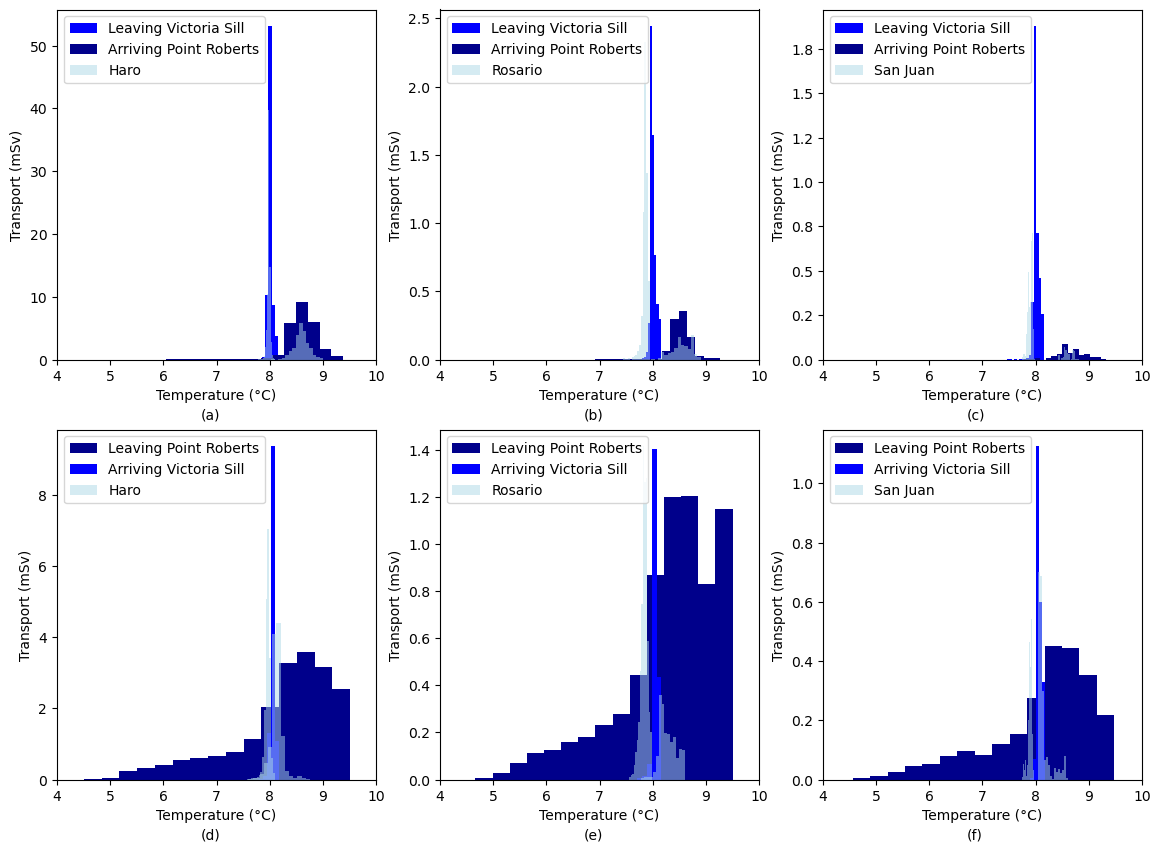

In [28]:
fig,[[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(2,3,figsize=(14,10))

bins = np.linspace(5, 9, 15)

ax2.hist(ros_fVS['init_temp'],bins=15,weights=ros_fVS['init_transp']/time/1000,color='blue',label='Leaving Victoria Sill')
ax2.hist(ros_bPR['init_temp'],bins=15,weights=ros_bPR['init_transp']/time/1000,color='darkblue',label='Arriving Point Roberts')
ax2.hist(ros_bPR['final_temp'],bins=15,weights=ros_bPR['final_transp']/time/1000,color='lightblue',alpha=0.5,label='Rosario')
ax2.hist(ros_fVS['final_temp'],bins=15,weights=ros_fVS['final_transp']/time/1000,color='lightblue',alpha=0.5)
ax2.set_ylabel('Transport (mSv)')
ax2.set_xlabel('Temperature (°C)')
ax2.legend()
ax1.hist(haro_fVS['init_temp'],bins=15,weights=haro_fVS['init_transp']/time/1000,color='blue',label='Leaving Victoria Sill')
ax1.hist(haro_bPR['init_temp'],bins=15,weights=haro_bPR['init_transp']/time/1000,color='darkblue',label='Arriving Point Roberts')
ax1.hist(haro_bPR['final_temp'],bins=15,weights=haro_bPR['final_transp']/time/1000,color='lightblue',alpha=0.5,label='Haro')
ax1.hist(haro_fVS['final_temp'],bins=15,weights=haro_fVS['final_transp']/time/1000,color='lightblue',alpha=0.5)
ax1.legend()
ax1.set_ylabel('Transport (mSv)')
ax1.set_xlabel('Temperature (°C)')
ax3.hist(sjc_fVS['init_temp'],bins=15,weights=sjc_fVS['init_transp']/time/1000,color='blue',label='Leaving Victoria Sill')
ax3.hist(sjc_bPR['init_temp'],bins=15,weights=sjc_bPR['init_transp']/time/1000,color='darkblue',label='Arriving Point Roberts')
ax3.hist(sjc_bPR['final_temp'],bins=15,weights=sjc_bPR['final_transp']/time/1000,color='lightblue',alpha=0.5,label='San Juan')
ax3.hist(sjc_fVS['final_temp'],bins=15,weights=sjc_fVS['final_transp']/time/1000,color='lightblue',alpha=0.5)
ax3.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{1}f}}'))
ax3.set_ylabel('Transport (mSv)')
ax3.set_xlabel('Temperature (°C)')
ax3.legend()
ax1.set_xlim([4,10])
ax2.set_xlim([4,10])
ax3.set_xlim([4,10])


ax5.hist(ros_fPR['init_temp'],bins=15,weights=ros_fPR['init_transp']/time/1000,color='darkblue',label='Leaving Point Roberts')
ax5.hist(ros_bVS['init_temp'],bins=5,weights=ros_bVS['init_transp']/time/1000,color='blue',label='Arriving Victoria Sill')
ax5.hist(ros_fPR['final_temp'],bins=15,weights=ros_fPR['final_transp']/time/1000,color='lightblue',alpha=0.5,label='Rosario')
ax5.hist(ros_bVS['final_temp'],bins=15,weights=ros_bVS['final_transp']/time/1000,color='lightblue',alpha=0.5)
ax5.set_ylabel('Transport (mSv)')
ax5.set_xlabel('Temperature (°C)')
ax5.legend()
ax4.hist(haro_fPR['init_temp'],bins=15,weights=haro_fPR['init_transp']/time/1000,color='darkblue',label='Leaving Point Roberts')
ax4.hist(haro_bVS['init_temp'],bins=5,weights=haro_bVS['init_transp']/time/1000,color='blue',label='Arriving Victoria Sill')
ax4.hist(haro_fPR['final_temp'],bins=15,weights=haro_fPR['final_transp']/time/1000,color='lightblue',alpha=0.5,label='Haro')
ax4.hist(haro_bVS['final_temp'],bins=15,weights=haro_bVS['final_transp']/time/1000,color='lightblue',alpha=0.5)
ax4.legend()
ax4.set_ylabel('Transport (mSv)')
ax4.set_xlabel('Temperature (°C)')

ax6.hist(sjc_fPR['init_temp'],bins=15,weights=sjc_fPR['init_transp']/time/1000,color='darkblue',label='Leaving Point Roberts')
ax6.hist(sjc_bVS['init_temp'],bins=5,weights=sjc_bVS['init_transp']/time/1000,color='blue',label='Arriving Victoria Sill')
ax6.hist(sjc_fPR['final_temp'],bins=15,weights=sjc_fPR['final_transp']/time/1000,color='lightblue',alpha=0.5,label='San Juan')
ax6.hist(sjc_bVS['final_temp'],bins=15,weights=sjc_bVS['final_transp']/time/1000,color='lightblue',alpha=0.5)
ax6.set_ylabel('Transport (mSv)')
ax6.set_xlabel('Temperature (°C)')
ax6.legend()
ax4.set_xlim([4,10])
ax5.set_xlim([4,10])
ax6.set_xlim([4,10])

ax1.text(0.45, -0.17, "(a)", transform=ax1.transAxes)
ax2.text(0.45, -0.17, "(b)", transform=ax2.transAxes)
ax3.text(0.45, -0.17, "(c)", transform=ax3.transAxes)

ax4.text(0.45, -0.17, "(d)", transform=ax4.transAxes)
ax5.text(0.45, -0.17, "(e)", transform=ax5.transAxes)
ax6.text(0.45, -0.17, "(f)", transform=ax6.transAxes)

fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/temp_modification_jan.png',bbox_inches='tight')

#### EJdF summer

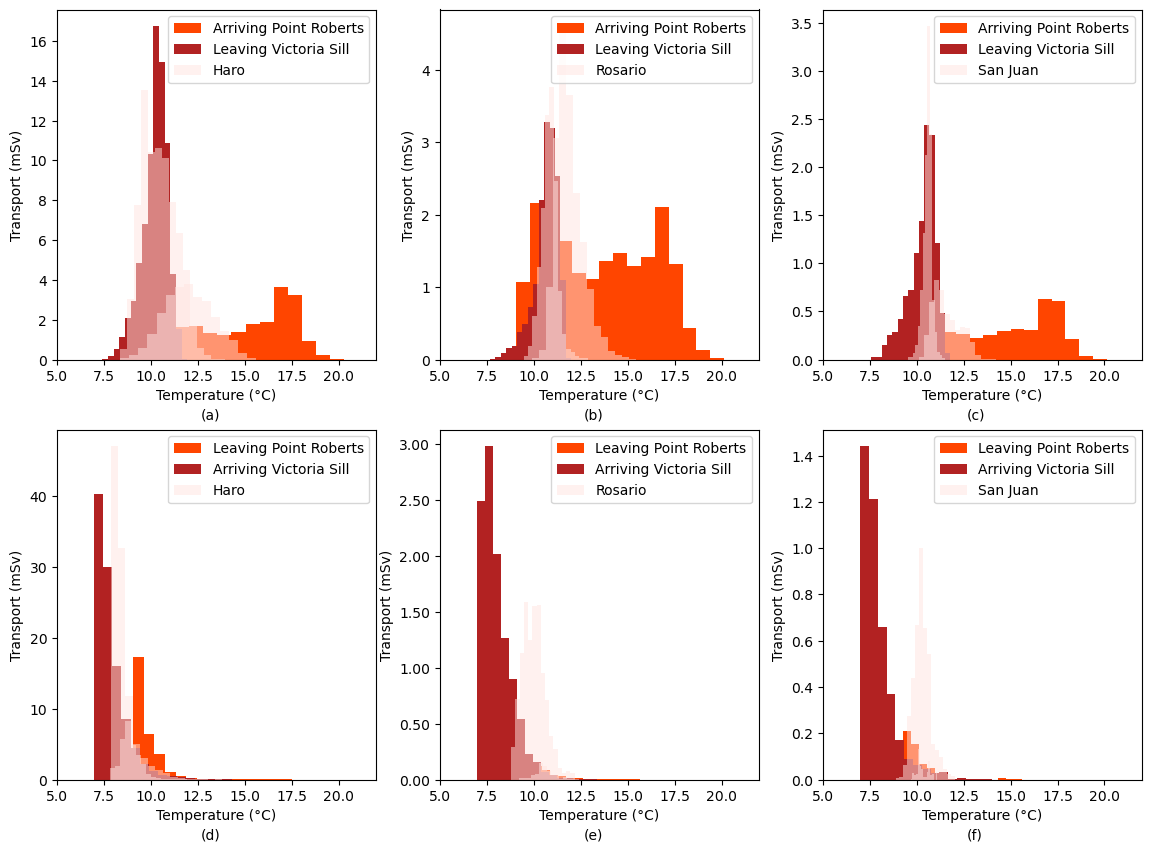

In [29]:
fig,[[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(2,3,figsize=(14,10))

ax2.hist(ros_fPR07['init_temp'],bins=15,weights=ros_fPR07['init_transp']/time/1000,color='orangered',label='Arriving Point Roberts')
ax2.hist(ros_bVS07['init_temp'],bins=15,weights=ros_bVS07['init_transp']/time/1000,color='firebrick',label='Leaving Victoria Sill')
ax2.hist(ros_bVS07['final_temp'],bins=15,weights=ros_bVS07['final_transp']/time/1000,color='mistyrose',alpha=0.5,label='Rosario')
ax2.hist(ros_fPR07['final_temp'],bins=15,weights=ros_fPR07['final_transp']/time/1000,color='mistyrose',alpha=0.5)
ax2.set_ylabel('Transport (mSv)')
ax2.set_xlabel('Temperature (°C)')
ax2.legend()
ax1.hist(haro_fPR07['init_temp'],bins=15,weights=haro_fPR07['init_transp']/time/1000,color='orangered',label='Arriving Point Roberts')
ax1.hist(haro_bVS07['init_temp'],bins=15,weights=haro_bVS07['init_transp']/time/1000,color='firebrick',label='Leaving Victoria Sill')
ax1.hist(haro_bVS07['final_temp'],bins=15,weights=haro_bVS07['final_transp']/time/1000,color='mistyrose',alpha=0.5,label='Haro')
ax1.hist(haro_fPR07['final_temp'],bins=15,weights=haro_fPR07['final_transp']/time/1000,color='mistyrose',alpha=0.5)
ax1.legend()
ax1.set_ylabel('Transport (mSv)')
ax1.set_xlabel('Temperature (°C)')
ax3.hist(sjc_fPR07['init_temp'],bins=15,weights=sjc_fPR07['init_transp']/time/1000,color='orangered',label='Arriving Point Roberts')
ax3.hist(sjc_bVS07['init_temp'],bins=15,weights=sjc_bVS07['init_transp']/time/1000,color='firebrick',label='Leaving Victoria Sill')
ax3.hist(sjc_bVS07['final_temp'],bins=15,weights=sjc_bVS07['final_transp']/time/1000,color='mistyrose',alpha=0.5,label='San Juan')
ax3.hist(sjc_fPR07['final_temp'],bins=15,weights=sjc_fPR07['final_transp']/time/1000,color='mistyrose',alpha=0.5)
ax3.set_ylabel('Transport (mSv)')
ax3.set_xlabel('Temperature (°C)')
ax3.legend()
ax1.set_xlim([5,22])
ax2.set_xlim([5,22])
ax3.set_xlim([5,22])

ax5.hist(ros_bPR07['init_temp'],bins=15,weights=ros_bPR07['init_transp']/time/1000,color='orangered',label='Leaving Point Roberts')
ax5.hist(ros_fVS07['init_temp'],bins=15,weights=ros_fVS07['init_transp']/time/1000,color='firebrick',label='Arriving Victoria Sill')
ax5.hist(ros_fVS07['final_temp'],bins=15,weights=ros_fVS07['final_transp']/time/1000,color='mistyrose',alpha=0.5,label='Rosario')
ax5.hist(ros_bPR07['final_temp'],bins=15,weights=ros_bPR07['final_transp']/time/1000,color='mistyrose',alpha=0.5)
ax5.set_ylabel('Transport (mSv)')
ax5.set_xlabel('Temperature (°C)')
ax5.legend()
ax4.hist(haro_bPR07['init_temp'],bins=15,weights=haro_bPR07['init_transp']/time/1000,color='orangered',label='Leaving Point Roberts')
ax4.hist(haro_fVS07['init_temp'],bins=15,weights=haro_fVS07['init_transp']/time/1000,color='firebrick',label='Arriving Victoria Sill')
ax4.hist(haro_fVS07['final_temp'],bins=15,weights=haro_fVS07['final_transp']/time/1000,color='mistyrose',alpha=0.5,label='Haro')
ax4.hist(haro_bPR07['final_temp'],bins=15,weights=haro_bPR07['final_transp']/time/1000,color='mistyrose',alpha=0.5)
ax4.legend()
ax4.set_ylabel('Transport (mSv)')
ax4.set_xlabel('Temperature (°C)')
ax6.hist(sjc_bPR07['init_temp'],bins=15,weights=sjc_bPR07['init_transp']/time/1000,color='orangered',label='Leaving Point Roberts')
ax6.hist(sjc_fVS07['init_temp'],bins=15,weights=sjc_fVS07['init_transp']/time/1000,color='firebrick',label='Arriving Victoria Sill')
ax6.hist(sjc_fVS07['final_temp'],bins=15,weights=sjc_fVS07['final_transp']/time/1000,color='mistyrose',alpha=0.5,label='San Juan')
ax6.hist(sjc_bPR07['final_temp'],bins=15,weights=sjc_bPR07['final_transp']/time/1000,color='mistyrose',alpha=0.5)
ax6.set_ylabel('Transport (mSv)')
ax6.set_xlabel('Temperature (°C)')
ax6.legend()
ax4.set_xlim([5,22])
ax5.set_xlim([5,22])
ax6.set_xlim([5,22])

ax5.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.{2}f}}'))


ax1.text(0.45, -0.17, "(a)", transform=ax1.transAxes)
ax2.text(0.45, -0.17, "(b)", transform=ax2.transAxes)
ax3.text(0.45, -0.17, "(c)", transform=ax3.transAxes)

ax4.text(0.45, -0.17, "(d)", transform=ax4.transAxes)
ax5.text(0.45, -0.17, "(e)", transform=ax5.transAxes)
ax6.text(0.45, -0.17, "(f)", transform=ax6.transAxes)

fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/temp_modification_jul.png',bbox_inches='tight')

#### SJGI Temperature

Text(0.45, -0.17, '(f)')

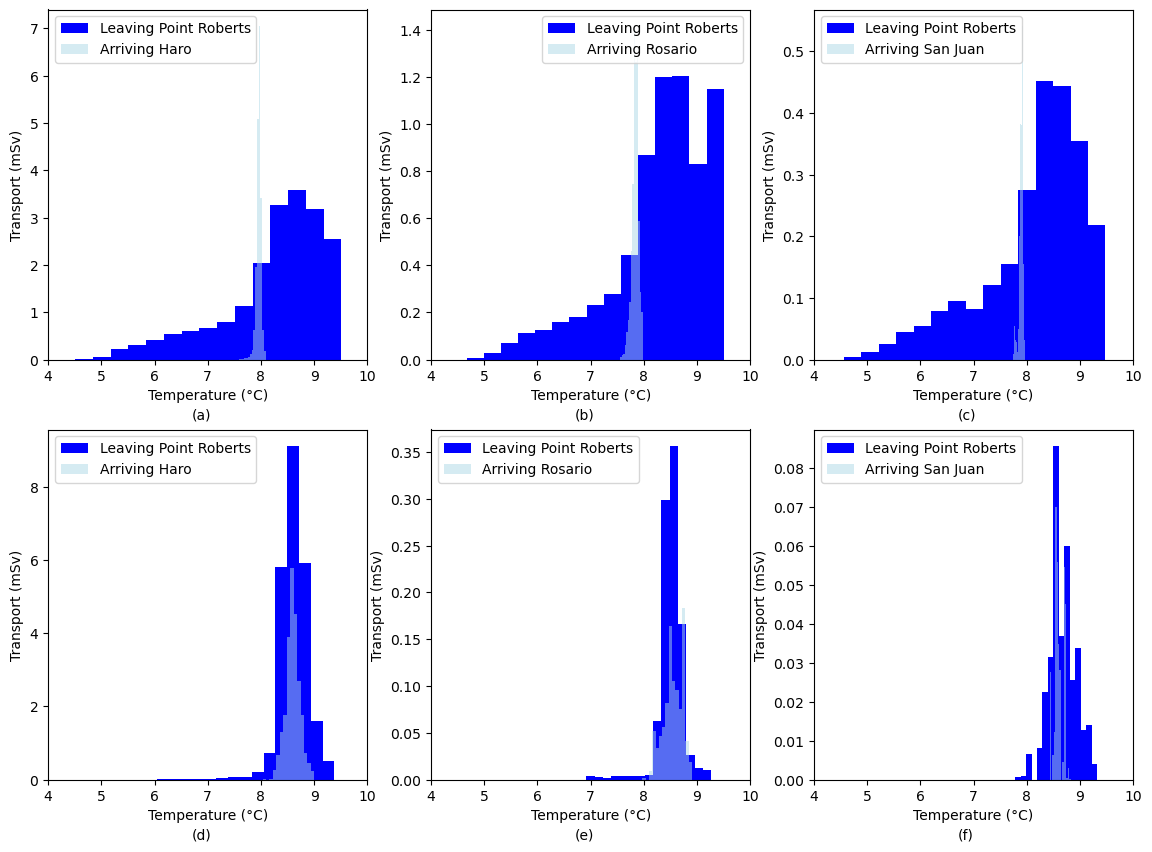

In [16]:
haro_bPR = get_secdata(data_dict['databpr'],6)
ros_bPR = get_secdata(data_dict['databpr'],4)
sjc_bPR = get_secdata(data_dict['databpr'],5)

fig,[[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(2,3,figsize=(14,10))

ax2.hist(ros_fPR['init_temp'],bins=15,weights=ros_fPR['init_transp']/time/1000,color='blue',label='Leaving Point Roberts')
ax2.hist(ros_fPR['final_temp'],bins=15,weights=ros_fPR['final_transp']/time/1000,color='lightblue',alpha=0.5,label='Arriving Rosario')
ax2.set_ylabel('Transport (mSv)')
ax2.set_xlabel('Temperature (°C)')
ax2.legend()
ax1.hist(haro_fPR['init_temp'],bins=15,weights=haro_fPR['init_transp']/time/1000,color='blue',label='Leaving Point Roberts')
ax1.hist(haro_fPR['final_temp'],bins=15,weights=haro_fPR['final_transp']/time/1000,color='lightblue',alpha=0.5,label='Arriving Haro')
ax1.legend()
ax1.set_ylabel('Transport (mSv)')
ax1.set_xlabel('Temperature (°C)')
ax3.hist(sjc_fPR['init_temp'],bins=15,weights=sjc_fPR['init_transp']/time/1000,color='blue',label='Leaving Point Roberts')
ax3.hist(sjc_fPR['final_temp'],bins=15,weights=sjc_fPR['final_transp']/time/1000,color='lightblue',alpha=0.5,label='Arriving San Juan')
ax3.set_ylabel('Transport (mSv)')
ax3.set_xlabel('Temperature (°C)')
ax3.legend()
ax1.set_xlim([4,10])
ax2.set_xlim([4,10])
ax3.set_xlim([4,10])

ax5.hist(ros_bPR['init_temp'],bins=15,weights=ros_bPR['init_transp']/time/1000,color='blue',label='Leaving Point Roberts')
ax5.hist(ros_bPR['final_temp'],bins=15,weights=ros_bPR['final_transp']/time/1000,color='lightblue',alpha=0.5,label='Arriving Rosario')
ax5.set_ylabel('Transport (mSv)')
ax5.set_xlabel('Temperature (°C)')
ax5.legend()
ax4.hist(haro_bPR['init_temp'],bins=15,weights=haro_bPR['init_transp']/time/1000,color='blue',label='Leaving Point Roberts')
ax4.hist(haro_bPR['final_temp'],bins=15,weights=haro_bPR['final_transp']/time/1000,color='lightblue',alpha=0.5,label='Arriving Haro')
ax4.legend()
ax4.set_ylabel('Transport (mSv)')
ax4.set_xlabel('Temperature (°C)')
ax6.hist(sjc_bPR['init_temp'],bins=15,weights=sjc_bPR['init_transp']/time/1000,color='blue',label='Leaving Point Roberts')
ax6.hist(sjc_bPR['final_temp'],bins=15,weights=sjc_bPR['final_transp']/time/1000,color='lightblue',alpha=0.5,label='Arriving San Juan')
ax6.set_ylabel('Transport (mSv)')
ax6.set_xlabel('Temperature (°C)')
ax6.legend()
ax4.set_xlim([4,10])
ax5.set_xlim([4,10])
ax6.set_xlim([4,10])

ax1.text(0.45, -0.17, "(a)", transform=ax1.transAxes)
ax2.text(0.45, -0.17, "(b)", transform=ax2.transAxes)
ax3.text(0.45, -0.17, "(c)", transform=ax3.transAxes)

ax4.text(0.45, -0.17, "(d)", transform=ax4.transAxes)
ax5.text(0.45, -0.17, "(e)", transform=ax5.transAxes)
ax6.text(0.45, -0.17, "(f)", transform=ax6.transAxes)

Text(0.45, -0.17, '(f)')

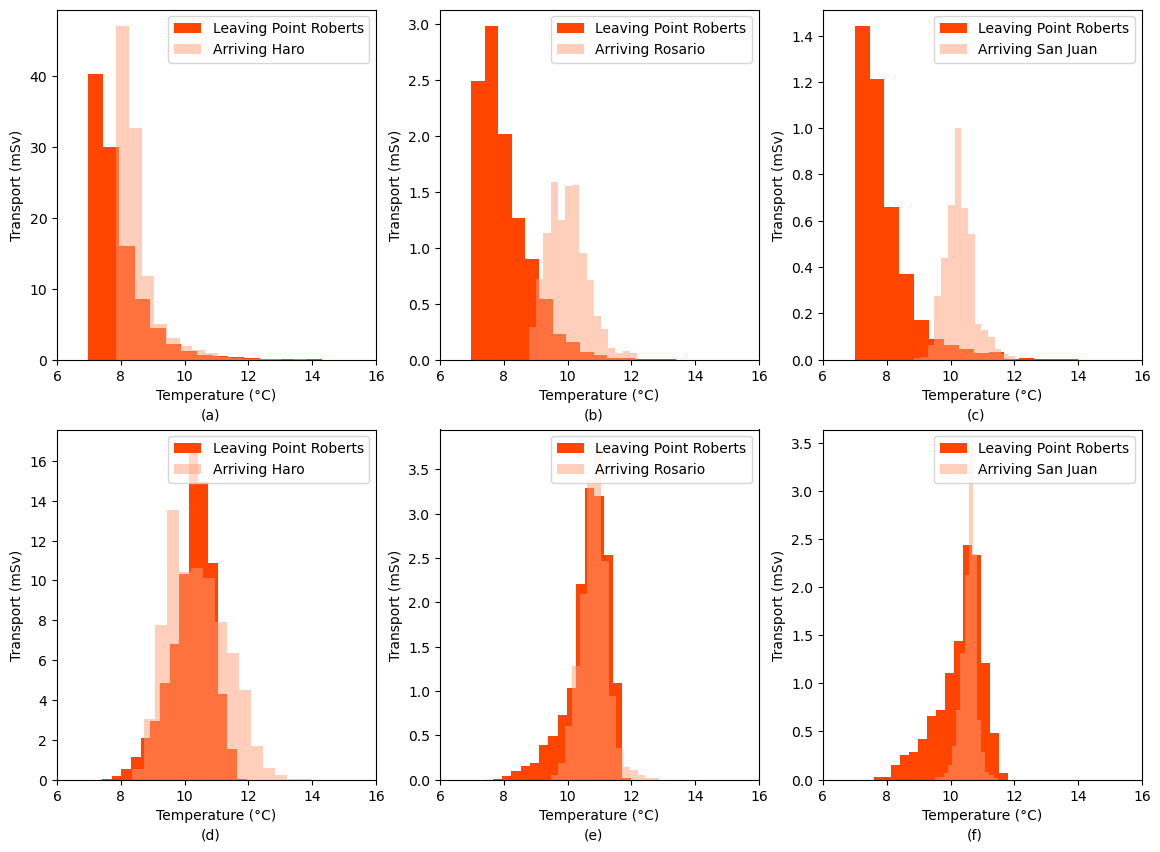

In [17]:
fig,[[ax1,ax2,ax3],[ax4,ax5,ax6]] = plt.subplots(2,3,figsize=(14,10))

ax2.hist(ros_fVS07['init_temp'],bins=15,weights=ros_fVS07['init_transp']/time/1000,color='orangered',label='Leaving Point Roberts')
ax2.hist(ros_fVS07['final_temp'],bins=15,weights=ros_fVS07['final_transp']/time/1000,color='lightsalmon',alpha=0.5,label='Arriving Rosario')
ax2.set_ylabel('Transport (mSv)')
ax2.set_xlabel('Temperature (°C)')
ax2.legend()
ax1.hist(haro_fVS07['init_temp'],bins=15,weights=haro_fVS07['init_transp']/time/1000,color='orangered',label='Leaving Point Roberts')
ax1.hist(haro_fVS07['final_temp'],bins=15,weights=haro_fVS07['final_transp']/time/1000,color='lightsalmon',alpha=0.5,label='Arriving Haro')
ax1.legend()
ax1.set_ylabel('Transport (mSv)')
ax1.set_xlabel('Temperature (°C)')
ax3.hist(sjc_fVS07['init_temp'],bins=15,weights=sjc_fVS07['init_transp']/time/1000,color='orangered',label='Leaving Point Roberts')
ax3.hist(sjc_fVS07['final_temp'],bins=15,weights=sjc_fVS07['final_transp']/time/1000,color='lightsalmon',alpha=0.5,label='Arriving San Juan')
ax3.set_ylabel('Transport (mSv)')
ax3.set_xlabel('Temperature (°C)')
ax3.legend()
ax1.set_xlim([6,16])
ax2.set_xlim([6,16])
ax3.set_xlim([6,16])

ax5.hist(ros_bVS07['init_temp'],bins=15,weights=ros_bVS07['init_transp']/time/1000,color='orangered',label='Leaving Point Roberts')
ax5.hist(ros_bVS07['final_temp'],bins=15,weights=ros_bVS07['final_transp']/time/1000,color='lightsalmon',alpha=0.5,label='Arriving Rosario')
ax5.set_ylabel('Transport (mSv)')
ax5.set_xlabel('Temperature (°C)')
ax5.legend()
ax4.hist(haro_bVS07['init_temp'],bins=15,weights=haro_bVS07['init_transp']/time/1000,color='orangered',label='Leaving Point Roberts')
ax4.hist(haro_bVS07['final_temp'],bins=15,weights=haro_bVS07['final_transp']/time/1000,color='lightsalmon',alpha=0.5,label='Arriving Haro')
ax4.legend()
ax4.set_ylabel('Transport (mSv)')
ax4.set_xlabel('Temperature (°C)')
ax6.hist(sjc_bVS07['init_temp'],bins=15,weights=sjc_bVS07['init_transp']/time/1000,color='orangered',label='Leaving Point Roberts')
ax6.hist(sjc_bVS07['final_temp'],bins=15,weights=sjc_bVS07['final_transp']/time/1000,color='lightsalmon',alpha=0.5,label='Arriving San Juan')
ax6.set_ylabel('Transport (mSv)')
ax6.set_xlabel('Temperature (°C)')
ax6.legend()
ax4.set_xlim([6,16])
ax5.set_xlim([6,16])
ax6.set_xlim([6,16])

ax1.text(0.45, -0.17, "(a)", transform=ax1.transAxes)
ax2.text(0.45, -0.17, "(b)", transform=ax2.transAxes)
ax3.text(0.45, -0.17, "(c)", transform=ax3.transAxes)

ax4.text(0.45, -0.17, "(d)", transform=ax4.transAxes)
ax5.text(0.45, -0.17, "(e)", transform=ax5.transAxes)
ax6.text(0.45, -0.17, "(f)", transform=ax6.transAxes)